# Marketing Mix Modelling

[описание](https://facebookexperimental.github.io/Robyn/docs/analysts-guide-to-MMM)
*   How much sales (online and offline) did each media channel drive?
*   What was the ROI of each marketing channel?
*   How should I allocate budget by channel so as to maximize my KPIs?
*   Where should my next marketing dollar go?
*   What is the optimal level of spend for each major marketing channel?
*   How would sales be impacted if I made X change to my marketing plan?
*   If I needed to cut my marketing budget by X%, where should the dollars come from?
*   How is performance of channels such as FB impacted by the way they are executed (e.g., buying objective, frequency, creative quality or targeting strategy used)?
*   Should we raise our prices? If so, by how much?
*   What is the impact of competitor advertising on the performance of our brands?
*   How much incremental revenue to trade and promotional activities drive?


[параметризация](https://lightweight-mmm.readthedocs.io/en/latest/models.html) MMM-модели

In [3]:
!git clone https://github.com/google/lightweight_mmm.git -q

In [4]:
import os
os.chdir('./lightweight_mmm/')

In [5]:
!pip install . -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.0/285.0 kB 28.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.2.0 requires matplotlib>=3.7.1, but you have matplotlib 3.6.1 which is incompatible.


In [6]:
! pip install numpyro -q

In [8]:
from lightweight_mmm.utils import simulate_dummy_data
from lightweight_mmm.preprocessing import CustomScaler
from lightweight_mmm.lightweight_mmm import LightweightMMM
import jax.numpy as jnp
from numpyro import distributions, set_host_device_count
set_host_device_count(2)
from lightweight_mmm.plot import plot_model_fit, plot_media_channel_posteriors, plot_response_curves, plot_bars_media_metrics, plot_out_of_sample_model_fit, plot_prior_and_posterior
from lightweight_mmm.optimize_media import find_optimal_budgets
import numpy as np

## Сгенерим синтетики

In [408]:
data_size = 250
media_names = ['tv', 'digital', 'paper', 'blogers', 'social_nets']
media_data, extra_features, target, costs = simulate_dummy_data(
    data_size=data_size,
    n_media_channels=len(media_names),
    n_extra_features=2,
    geos=1) # Or geos=1 for national model

In [409]:
costs

Array([497.5455 , 505.35278, 504.02472, 496.35602, 500.24567], dtype=float32)

что на вход

*   таргет (продажи / офлайн траффик / траффик на сайт etc)
*   внешние фичи -- макро-факторы, погода и пр
*   сезонность (уже в модели)
*   медиа данные двух типов:
  *   медиа инвестиции (сколько по периодам на конкретные каналы тратили -- например еженедельно на какой канал сколько тратили)
  *   медиа показатели (dig: impressions, tv: TRP -- target rating points, audience)

In [410]:
# Simple split of the data based on time.
split_point = data_size - data_size // 10

media_data_train = media_data[:split_point, :]
target_train = target[:split_point]
extra_features_train = extra_features[:split_point, :]

extra_features_test = extra_features[split_point:, :]
target_test = target[split_point:]
media_data_test = media_data[split_point:, :]

# Scale data
media_scaler = CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = CustomScaler(divide_operation=jnp.mean)
target_scaler = CustomScaler(divide_operation=jnp.mean)
# scale cost up by N since fit() will divide it by number of time periods
cost_scaler = CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs_scaled = cost_scaler.fit_transform(costs)

media_data_test = media_scaler.transform(media_data_test)
#target_test = target_scaler.transform(target_test)
extra_features_test = extra_features_scaler.transform(extra_features_test)

In [411]:
# Fit model.
mmm = LightweightMMM(model_name = 'carryover') # carryover, adstock, hill_adstock
mmm.media_names = media_names
mmm.fit(media=media_data_train,
        media_names=media_names,
        extra_features=extra_features_train,
        media_prior=costs_scaled,
        target=target_train,
        number_warmup=2000,
        number_samples=2000,
        number_chains=1,
        seed = 42)

sample: 100%|██████████| 4000/4000 [11:02<00:00,  6.04it/s, 255 steps of size 1.01e-02. acc. prob=0.91]


In [412]:
costs_scaled

Array([0.9936901, 1.0092826, 1.0066302, 0.9913144, 0.9990828], dtype=float32)

Что за параметры?

In [413]:
mmm.print_summary()
# The rule of thumb is that r_hat values for all parameters are less than 1.1.


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.40      0.26      0.37      0.00      0.77   1181.36      1.00
ad_effect_retention_rate[1]      0.31      0.15      0.31      0.05      0.54    393.36      1.00
ad_effect_retention_rate[2]      0.52      0.29      0.52      0.11      1.00    484.14      1.00
ad_effect_retention_rate[3]      0.32      0.28      0.24      0.00      0.77    716.42      1.00
ad_effect_retention_rate[4]      0.26      0.14      0.25      0.01      0.46    680.64      1.00
     coef_extra_features[0]     -0.06      0.01     -0.06     -0.07     -0.04   1187.94      1.00
     coef_extra_features[1]     -0.04      0.01     -0.04     -0.05     -0.03   1584.50      1.00
              coef_media[0]      0.02      0.02      0.01      0.00      0.04   1063.37      1.01
              coef_media[1]      0.17      0.03      0.17      0.13      0.21    798.62      1.00
              coef_

Что такое r_hat?    
Статистика Гельмана-Рубина.   
Для интересующихся вот [критерии сходимости](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html).    
там же и про n_eff

Если коротко, то критерий такой:


  * n_eff - crude measure of effective sample size. The low value for the effective sample size (n_eff), particularly for tau, and the number of divergent transitions looks problematic.
  *   r_hat - potential scale reduction factor on split chains. The values above 1 for the split Gelman Rubin diagnostic (r_hat) indicates that the chain has not fully converged.

Почему MCMC для семмплирования/ оптимизации используют когда пространство плохое (например ввиду мультиколлинеарности) -- [введение в вероятности, стр. 536](https://drive.google.com/file/d/1VmkAAGOYCTORq1wxSQqy255qLJjTNvBI/view)

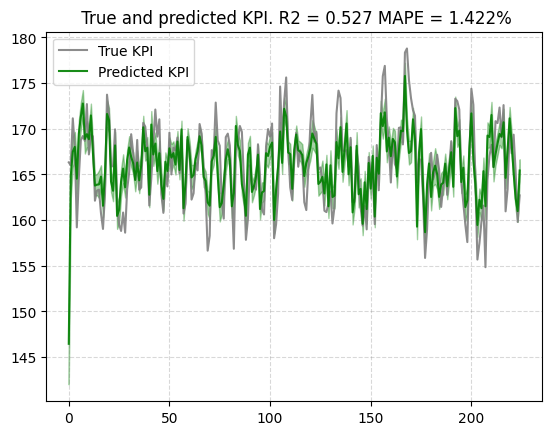

In [415]:
plot_model_fit(media_mix_model=mmm, target_scaler=target_scaler)

In [416]:
prediction = mmm.predict(
    media=media_data_test,
    extra_features=extra_features_test,
    target_scaler=target_scaler
)

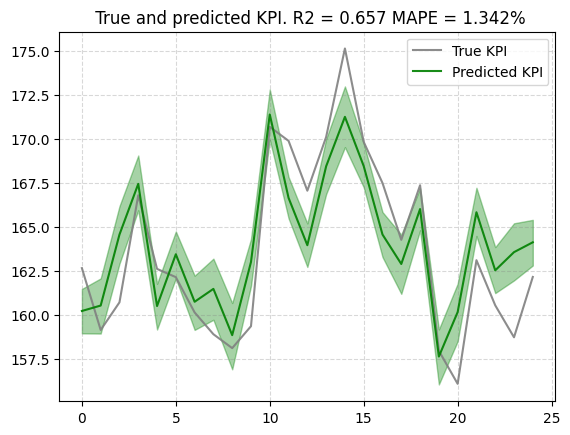

In [417]:
plot_out_of_sample_model_fit(out_of_sample_predictions = prediction, out_of_sample_target = target_test)

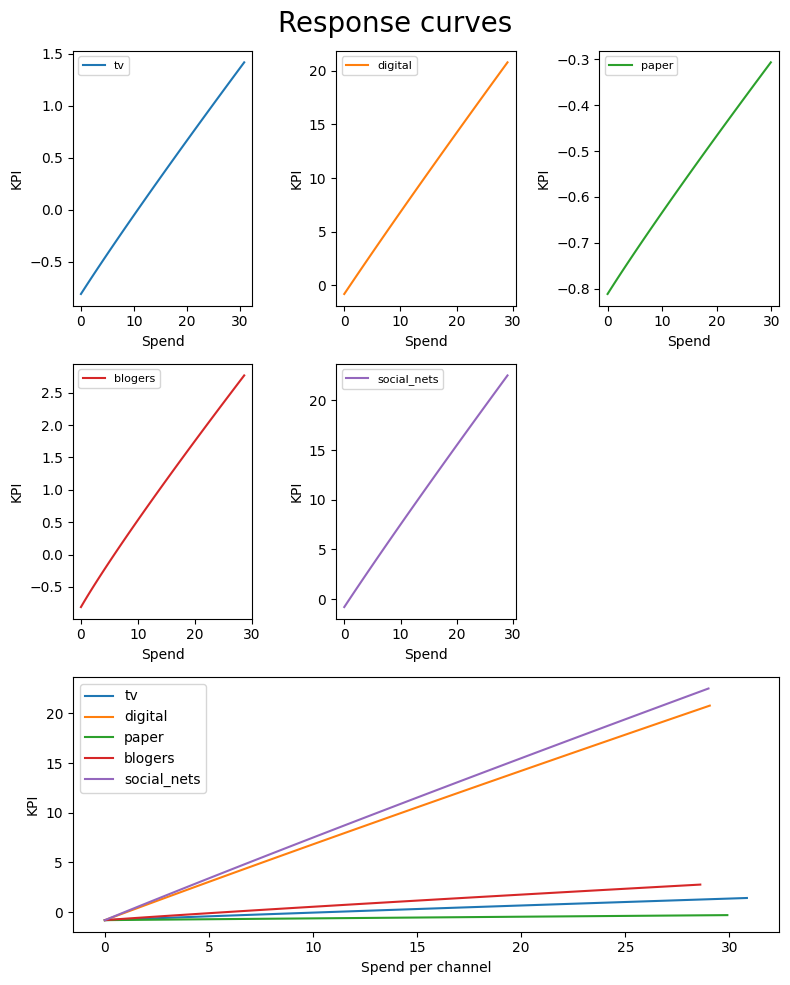

In [418]:
plot_response_curves(media_mix_model=mmm, media_scaler=media_scaler, target_scaler=target_scaler)

Форма не очень -- проблема синтетических данных.    
В реальном мире кривые должны выполаживаться (насыщаться) или иметь S-образную форму (сначала быстрый рост, потом насыщение)

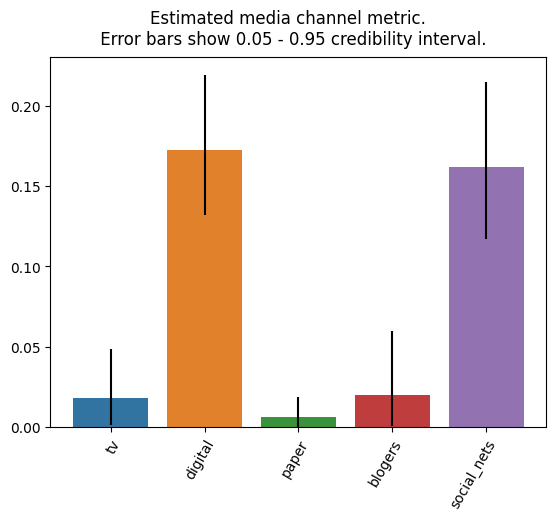

In [419]:
media_effect_hat, roi_hat = mmm.get_posterior_metrics(costs, cost_scaler = cost_scaler, target_scaler = target_scaler)
plot_bars_media_metrics(metric=media_effect_hat, channel_names=media_names)

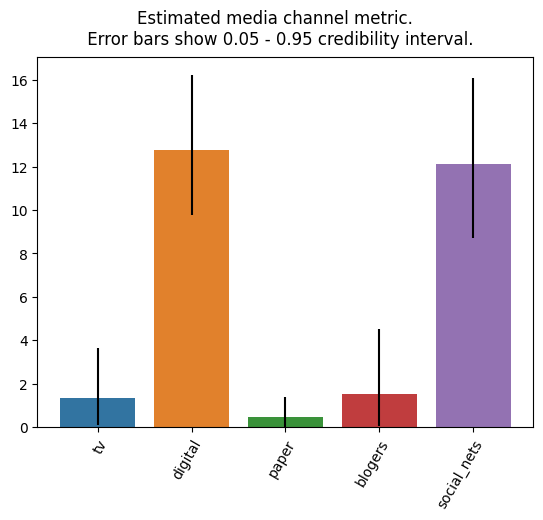

In [420]:
plot_bars_media_metrics(metric=roi_hat, channel_names=media_names)

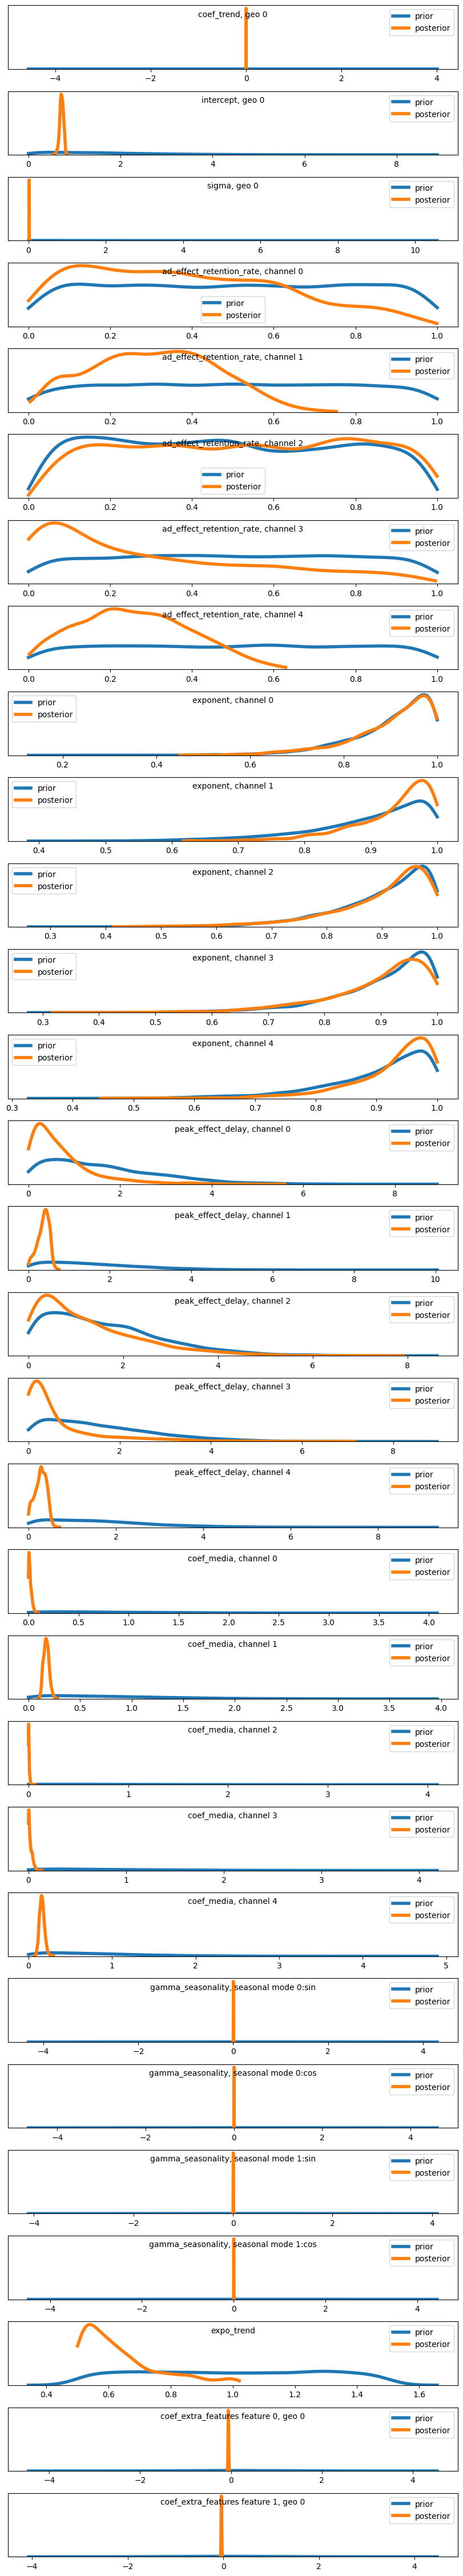

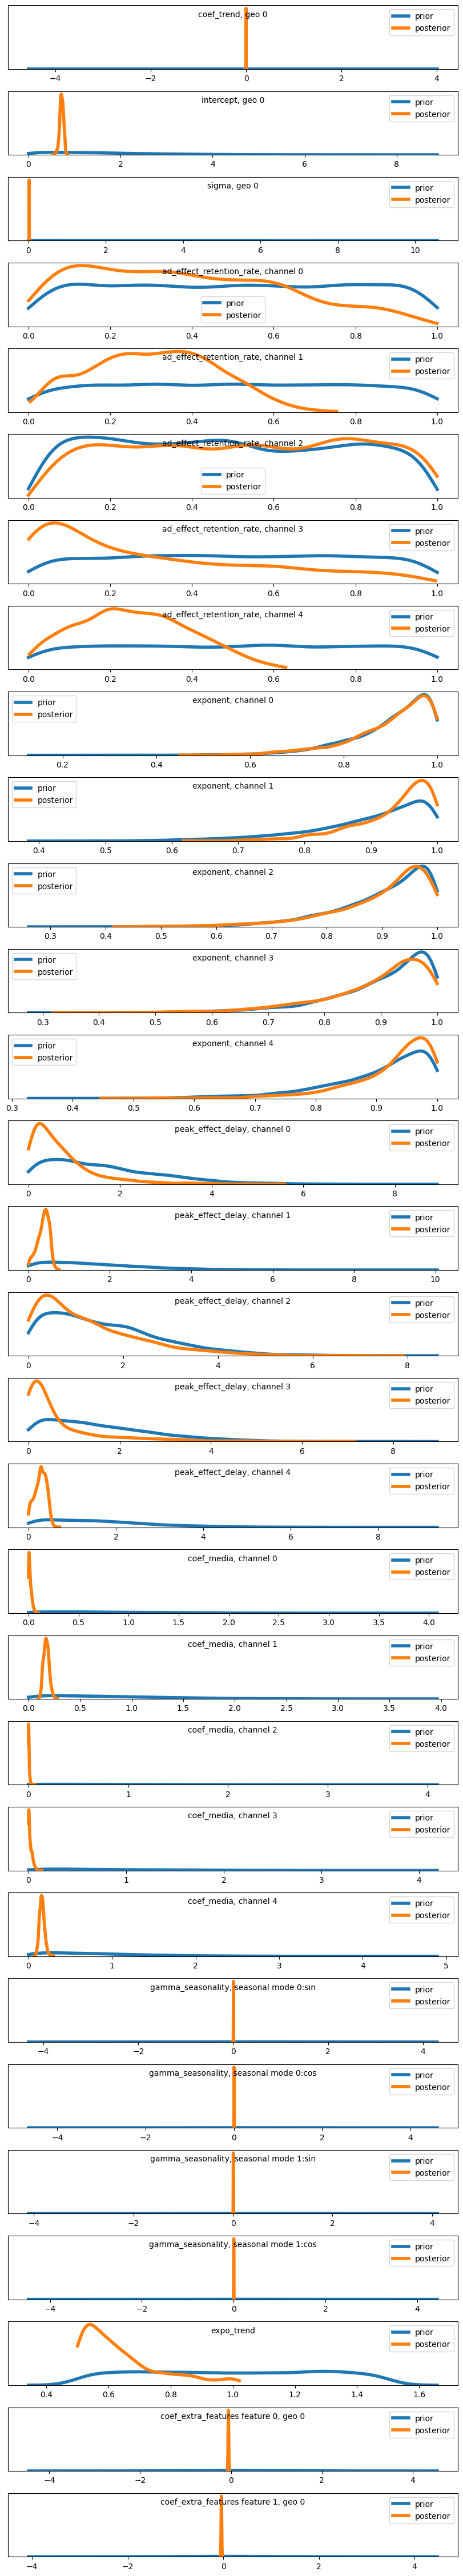

In [421]:
plot_prior_and_posterior(media_mix_model=mmm)

## Оптимильная аллокация бюджета

In [423]:
n_time_periods = len(target_test)
prices = jnp.ones(mmm.n_media_channels)
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods
budget

Array(2503.525, dtype=float32)

In [ ]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_test,
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=123)

In [ ]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

In [ ]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

In [ ]:
# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

In [428]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(Array(2503.525, dtype=float32), Array(2503.525, dtype=float32))

In [429]:
from lightweight_mmm.plot import plot_pre_post_budget_allocation_comparison

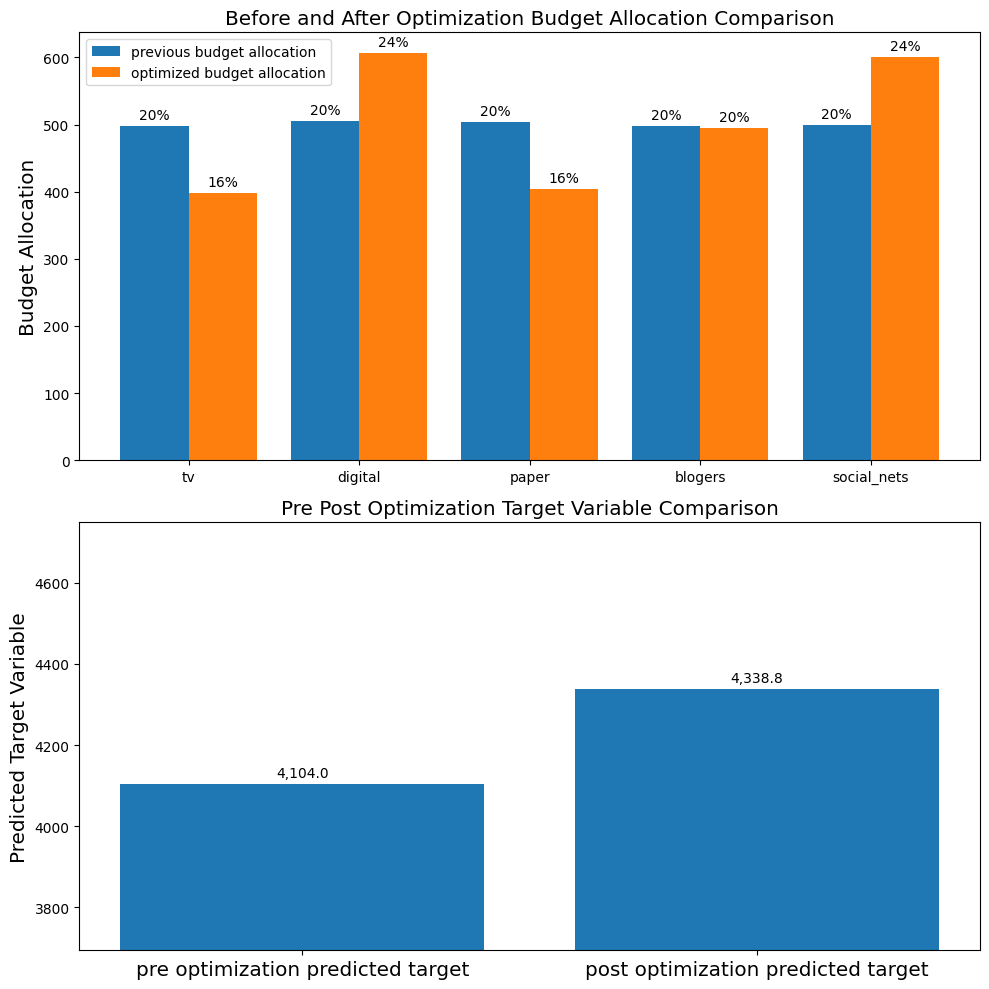

In [430]:
plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(10,10))

In [431]:
from lightweight_mmm.utils import save_model
from tabulate import tabulate
save_model(mmm, file_path='./mmm_eq.pkl')
all = []
for x, y, z in zip(media_names, solution.x, [float(x) for x in previous_media_allocation]):
  all.append([f'{x}',f'new {y:2.2f}', f'old {z:2.2f}'])
print(tabulate(all))

-----------  ----------  ----------
tv           new 398.29  old 497.39
digital      new 606.98  old 505.35
paper        new 403.45  old 503.84
blogers      new 494.64  old 497.27
social_nets  new 600.17  old 499.68
-----------  ----------  ----------


# Реальный датасет

In [10]:
!git clone https://github.com/jamesrawlins1000/Market-mix-modelling-data

Cloning into 'Market-mix-modelling-data'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6
Receiving objects: 100% (6/6), 381.75 KiB | 2.16 MiB/s, done.


In [11]:
os.chdir('./Market-mix-modelling-data/')

In [12]:
import pandas as pd
real_data = pd.read_excel('MMM_data.xlsx')

In [13]:
real_data

,TV Manufacturing Brand,DATE,DEMAND,Consumer Price Index (CPI),Consumer Confidence Index(CCI),Producer Price Index (PPI),Unit Price ($),POS/ Supply Data,SALES ($),Advertising Expenses (SMS),Advertising Expenses(Newspaper ads),Advertising Expenses(Radio),Advertising Expenses(TV),Advertising Expenses(Internet),GRP (NewPaper ads),GRP(SMS),GRP(Radio,GRP(Internet),GRP(TV)
0,TV Manufacturing & Supplier Unit,2010-01-01,4384,104.9,96.3,106.7,361.62,4240,1533268.80,77.4819,14.104193,112.3370,1479.4565,722.571,95.333,11.8398,91.0000,276.3636,756.5909
1,TV Manufacturing & Supplier Unit,2010-01-02,4366,104.9,96.3,106.7,361.62,4266,1542670.92,73.4783,13.298758,105.7133,1369.8913,717.857,114.957,27.8039,111.9091,291.3182,860.1364
2,TV Manufacturing & Supplier Unit,2010-01-03,4006,104.9,96.3,106.7,361.62,4206,1520973.72,80.6093,13.200691,108.7702,1428.0645,653.333,113.090,0.0000,94.6364,282.7273,751.9545
3,TV Manufacturing & Supplier Unit,2010-01-04,4076,104.9,96.3,106.7,361.62,4176,1510125.12,65.9319,12.721429,93.3065,1309.3548,622.095,72.442,0.0000,98.5909,306.3182,749.4545
4,TV Manufacturing & Supplier Unit,2010-01-05,4834,104.9,96.3,106.7,361.62,5234,1892719.08,77.4819,14.104193,112.3370,1479.4565,722.571,95.333,11.8398,91.0000,276.3636,756.5909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2608,TV Manufacturing & Supplier Unit,2017-02-21,7312,101.4,100.3,103.3,361.62,6974,2521937.88,60.6667,13.488857,76.7250,1399.6615,4168.952,272.036,0.0000,93.9545,222.7727,805.9091
2609,TV Manufacturing & Supplier Unit,2017-02-22,6456,101.4,100.3,103.3,361.62,6123,2214199.26,59.1026,13.206593,78.6058,1369.3491,3984.429,817.581,31.3919,81.9091,225.1818,816.2727
2610,TV Manufacturing & Supplier Unit,2017-02-23,6060,101.4,100.3,103.3,361.62,5989,2165742.18,61.1351,12.775135,76.2872,1341.7297,3943.524,1288.844,31.1817,98.6818,224.5455,855.8636
2611,TV Manufacturing & Supplier Unit,2017-02-24,5980,101.4,100.3,103.3,361.62,5877,2125240.74,53.7865,12.940132,74.9424,1323.5526,5732.000,540.757,31.5487,111.0455,232.8636,791.3636


In [14]:
for col in real_data.columns:
  print(col)

TV Manufacturing Brand
DATE
DEMAND 
Consumer Price Index (CPI)
Consumer Confidence Index(CCI)
Producer Price Index (PPI)
Unit Price ($)
POS/ Supply Data
SALES ($)
Advertising Expenses (SMS)
Advertising Expenses(Newspaper ads)
Advertising Expenses(Radio)
Advertising Expenses(TV)
Advertising Expenses(Internet)
GRP (NewPaper ads)
GRP(SMS)
GRP(Radio
GRP(Internet)
GRP(TV)


*   TV Manufacturing Brand - какое название юнита
*   DATE - дата
*   DEMAND - спрос на товар
*   Consumer Price Index (CPI) - индекс роста потребительских цен
*   Consumer Confidence Index(CCI) - индекс уверенности потребителя в *   стабильности экономики. По сути это индекс инфляционных настроений
*   Producer Price Index (PPI) - индекс цен производителя
*   Unit Price (\$) - цена\ за\ юнит
*   POS/ Supply Data - объемы доступных товаров для продажи в точках по идее
*   SALES ($) - выручка с фактически проданных товаров
*   Advertising Expenses (SMS) - затраты на канал СМС
*   Advertising Expenses(Newspaper ads) - затраты на газеты и журналы
*   Advertising Expenses(Radio) - затраты на Радио рекламу
*   Advertising Expenses(TV) - затраты на ТВ рекламу
*   Advertising Expenses(Internet) - затраты на Диджитал рекламу
*   GRP (NewPaper ads) - Gross Rating Points, рейтинги показов рекламы в газетах и журналах (доля покрытой аудитории * частоту просмотров, от всей аудитории страны/региона. Считаем, что это *   некая относительная метрика охвата аудитории)
*   GRP(SMS) - то же самое для СМС
*   GRP(Radio - для Радио
*   GRP(Internet) - для Диджитала (странно, что тут GRP, потому что в диджитале объемы меряют показами. Наверное, тут что-то типа доли Охваченной аудитории)
*   GRP(TV)  - то же самое для ТВ

In [25]:
real_media_data = np.array(real_data[[ 'GRP(SMS)', 'GRP (NewPaper ads)', 'GRP(Radio', 'GRP(Internet)', 'GRP(TV)']])
# 'Advertising Expenses (SMS)', 'Advertising Expenses(Newspaper ads)', 'Advertising Expenses(Radio)', 'Advertising Expenses(TV)',
                            #  'Advertising Expenses(Internet)',
real_target = np.array(real_data['SALES ($)'])
real_extra_features = np.array(real_data[['DEMAND ', 'Consumer Price Index (CPI)', 'Consumer Confidence Index(CCI)', 'Producer Price Index (PPI)', 'Unit Price ($)']])
real_media_data

real_data_size = len(real_target)
real_media_names = ['SMS', 'Newspaper ads', 'Radio', 'TV', 'Internet']
real_media_prior = real_data[['Advertising Expenses (SMS)', 'Advertising Expenses(Newspaper ads)', 'Advertising Expenses(Radio)', 'Advertising Expenses(TV)',
                             'Advertising Expenses(Internet)']].sum() / real_data[['Advertising Expenses (SMS)', 'Advertising Expenses(Newspaper ads)', 'Advertising Expenses(Radio)', 'Advertising Expenses(TV)',
                             'Advertising Expenses(Internet)']].sum().sum()
real_media_prior = np.array(real_media_prior)
# Simple split of the data based on time.
real_split_point = real_data_size - real_data_size // 10

real_media_data_train = real_media_data[:real_split_point, :]
real_target_train = real_target[:real_split_point]
real_extra_features_train = real_extra_features[:real_split_point, :]

real_extra_features_test = real_extra_features[real_split_point:, :]
real_target_test = real_target[real_split_point:]
real_media_data_test = real_media_data[real_split_point:, :]

# Scale data
real_media_scaler = CustomScaler(divide_operation=jnp.mean)
real_extra_features_scaler = CustomScaler(divide_operation=jnp.mean)
real_target_scaler = CustomScaler(divide_operation=jnp.mean)
# scale cost up by N since fit() will divide it by number of time periods
real_cost_scaler = CustomScaler(divide_operation=jnp.mean)



In [26]:
real_media_data_train = real_media_scaler.fit_transform(real_media_data_train)
real_extra_features_train = real_extra_features_scaler.fit_transform(real_extra_features_train)
real_target_train = real_target_scaler.fit_transform(real_target_train)
real_costs_scaled = real_cost_scaler.fit_transform(real_media_prior)

real_media_data_test = real_media_scaler.transform(real_media_data_test)
#target_test = target_scaler.transform(target_test)
real_extra_features_test = real_extra_features_scaler.transform(real_extra_features_test)

In [33]:
# Fit model.
real_mmm = LightweightMMM(model_name = 'hill_adstock') # carryover, adstock, hill_adstock
real_mmm.media_names = real_media_names
real_mmm.fit(media=real_media_data_train,
        media_names=real_media_names,
        extra_features=real_extra_features_train,
        media_prior=real_costs_scaled,
        target=real_target_train,
        number_warmup=500,
        number_samples=500,
        number_chains=1,
        seed = 42)

sample: 100%|██████████| 1000/1000 [12:17<00:00,  1.36it/s, 1023 steps of size 1.34e-03. acc. prob=0.94]


In [34]:
real_mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.90      0.01      0.90      0.88      0.92    119.89      1.00
             coef_extra_features[1]     -3.76      0.63     -3.82     -4.76     -2.81     44.45      1.01
             coef_extra_features[2]     -1.62      0.19     -1.61     -1.95     -1.33    116.85      1.01
             coef_extra_features[3]      0.63      0.35      0.62      0.02      1.15     62.94      1.00
             coef_extra_features[4]      0.53      0.08      0.54      0.41      0.66     46.06      1.06
                      coef_media[0]      0.04      0.03      0.03      0.00      0.08    131.52      1.00
                      coef_media[1]      0.05      0.01      0.05      0.02      0.07      9.18      1.14
                      coef_media[2]      0.08      0.05      0.08      0.01      0.16     22.42      1.05
                      coef_media[3]      2.22

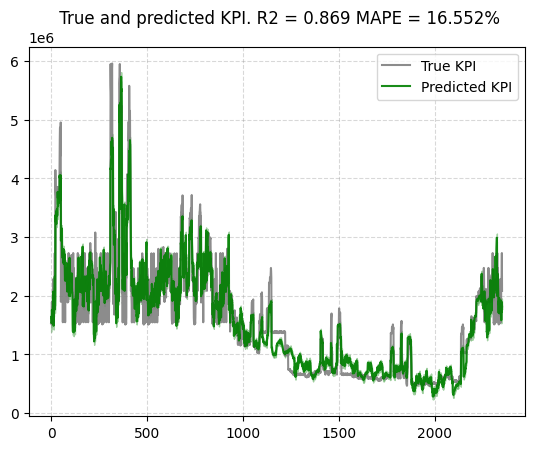

In [35]:
plot_model_fit(media_mix_model=real_mmm, target_scaler=real_target_scaler)

In [36]:
real_prediction = real_mmm.predict(
    media=real_media_data_test,
    extra_features=real_extra_features_test,
    target_scaler=real_target_scaler
)

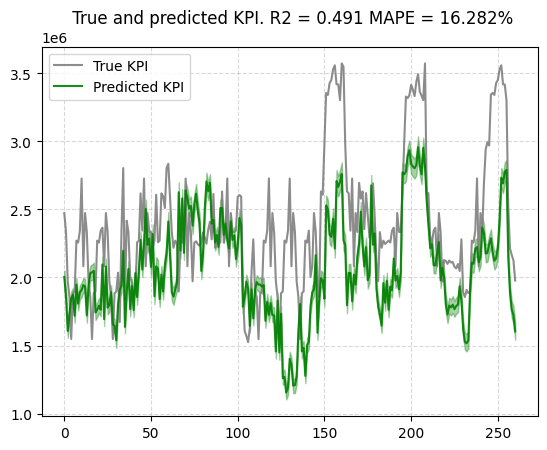

In [37]:
plot_out_of_sample_model_fit(out_of_sample_predictions = real_prediction, out_of_sample_target = real_target_test)

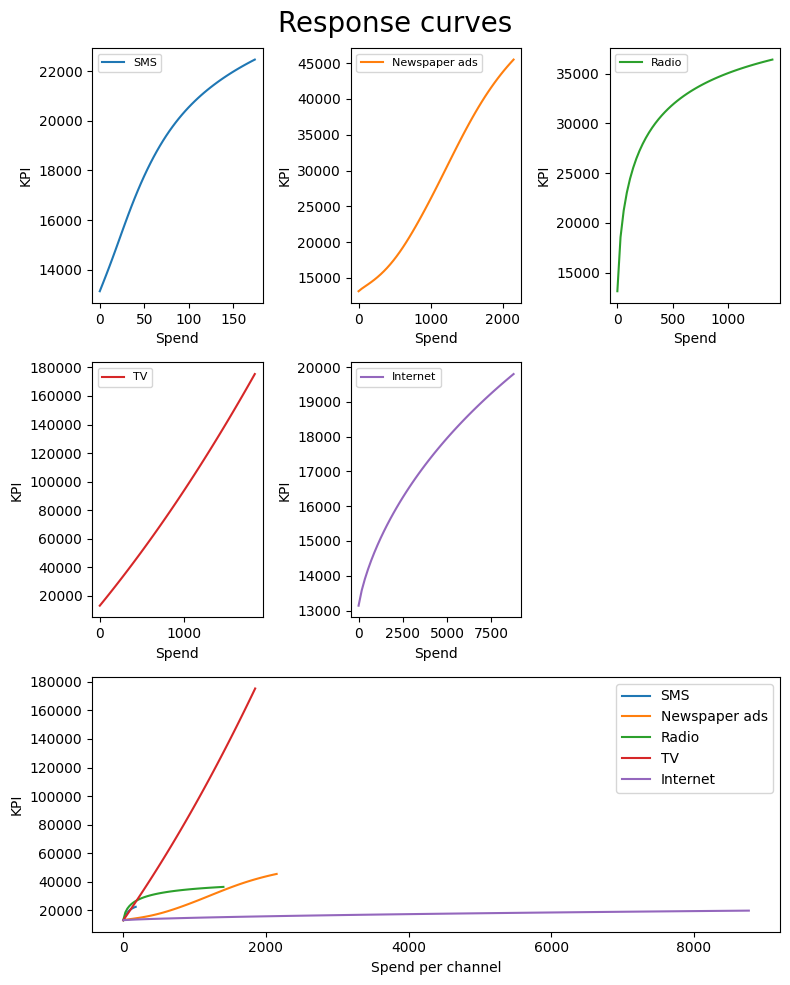

In [38]:
plot_response_curves(media_mix_model=real_mmm, media_scaler=real_media_scaler, target_scaler=real_target_scaler)

# Вопросы

Как определить границы применимости модели?    
Как в среднем атрибуцировать продажи по каналам?    

adstock -- лаг от старого рекламного импульса.  
saturation -- не можем с той же эффективностью долбить людей рекламой.  

обычно клиенту показывают
1.   респонс-кривые
2.   график декомпозиции kpi по каналам / макрофакторам -- для стратегического планирования
3.   рекомендованный media mix на следующий период -- при ограничениях от клиента (бюджет, лимиты по доле каналов)

Ridge deals with multicollinearity by shrinking the coefficients which might not be what you want - it might say one channel has less of an impact as it actually does in reality. You can correct for this partially by calibrating the model with the results of a lift test. Bayesian MCMC primarily deals with multicolinearity through informative priors - which can be edited in lightweight mmm in the models.py file. The other feature that helps is using geo level data - because there's likely to be more variance between variables across regions than there is nationally. If you think about it multicollinearity is saying the data can't tell you much about the relative impact of two channels - the true solution is to get better data by testing increases or decreases in spend for the correlated variables.

In [ ]:

примеры распределений

https://github.com/slavakx/medium_posts
